## Installments and Imports


In [1]:
# Adapted from example_costs lecture
!pip install -r requirements.txt
import cfe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Missing dependencies for OracleDemands.


In [2]:
# Load data
quant = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='Quantities')
hh = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='HH Characteristics')
expend = pd.read_excel('Bukidnon 2003.xlsx',sheet_name ='Expenditures')
nut = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='FCT')

# Load results
r = cfe.from_dataset("BUK.ds",engine='netcdf4')

## Filtering data by household characteristics

In [3]:
# Women of childbearing age (potential mothers)
pm_hh = hh[hh[['Females 15-20','Females 20-30']].sum(axis=1) > 2]

# Large household, lots of kids
ch_hh = pm_hh[pm_hh['log HSize'] > 2]
ch_j = ch_hh['j']
r = r.sel(j=ch_j)

r

<xarray.Result>
Dimensions:           (i: 29, k: 19, variable: 1, m: 1, j: 52, t: 1, kp: 19)
Coordinates:
  * i                 (i) object 'Bagoong' 'Banana' ... 'Talong' 'Tomatoes'
  * k                 (k) object 'Males 0-1' 'Males 1-5' ... 'log HSize'
  * variable          (variable) float64 2.003e+03
  * m                 (m) object 'Bukidnon'
  * j                 (j) float64 106.0 115.0 123.0 144.0 ... 775.0 785.0 88.0
  * t                 (t) float64 2.003e+03
  * kp                (kp) object 'Males 0-1' 'Males 1-5' ... 'log HSize'
Data variables: (12/20)
    alpha             float64 nan
    beta              (i) float64 0.2534 0.5821 0.4597 ... 0.2713 0.5006 0.4771
    delta             (k, i) float64 -0.05259 0.2786 0.245 ... -0.4271 -0.4551
    prices            (variable, i, m) float64 0.03719 0.0214 ... 0.02372
    characteristics   (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... 2.079 2.773 2.303
    loglambdas        (j, t, m) float64 0.3338 -0.6932 ... 0.7803 0.09709
    ...                ...
    se_beta           float64 nan
    se_alpha          float64 nan
    se_a              (i, t, m) float64 0.03899 0.05199 ... 0.05059 0.04981
    y                 (i, j, t, m) float64 2.015 2.708 1.504 ... nan 2.303 1.099
    logp              (variable, i, m) float64 -3.292 -3.844 ... -4.168 -3.741
    z                 (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... 2.079 2.773 2.303
Attributes:
    firstround:            2003.0
    min_proportion_items:  0.125
    min_xproducts:         30
    all_tm:                True
    common_alpha:          True
    useless_expenditures:  False
    stderr_tol:            0.01
    indices:               Indices(j='j', t='t', m='m', i='i', k='k')
    iterate:               False
    verbose:               False

### Ceteris Paribus



In [4]:
# We begin by setting up some benchmarks for prices and budgets, 
# so the things we don’t want to change we can hold fixed.

# First year, first market, and some good.
my_t = r.coords['t'].data.flatten()[0] # Period
my_m = r.coords['m'].data.flatten()[0] # Market
my_i = 'Sardines' 

# prices are in $ per gram
p = r.prices.sel(m=my_m,drop=True)
phat = p.to_dataframe('i').dropna().squeeze().loc[2003]

# ref prices same units
ref_price = r.prices.sel(i=my_i,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

phat

i
Bagoong                          0.037190
Banana                           0.021401
Beef                             0.135031
Carrots                          0.027822
Chicken                          0.097764
Coffee                           0.732034
Cooking oil                      0.038578
Eggs                             0.092641
Food made from flour             0.016472
Fresh fish                       0.046502
Mangoes                          0.045497
Milk                             0.277523
Milo                             0.217887
Mongo and other products         0.038700
Onions                           0.043971
Peanut                           0.170558
Pork                             0.102934
Potato                           0.028599
Processed meat like longanisa    0.144143
Rice                             0.021202
Salt                             0.015549
Sardines                         0.078127
Sea weed                         0.035359
Soybean and other products      

### Simple Policy Experiments: Changing Budget



In [5]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
xbar = r.get_predicted_expenditures().sel(t=my_t,m=my_m).sum('i')

# Drop households with /no/ predicted expenditures
xbar = xbar.where(xbar>0)

x0 = xbar.quantile(0.5,'j') # Budget (median household)

# Range of budgets to explore
X = np.linspace(x0/10,x0*5,50)

### Simple Policy Experiments: Changing Prices



#### Marshallian vs. Hicksian Demand Curves



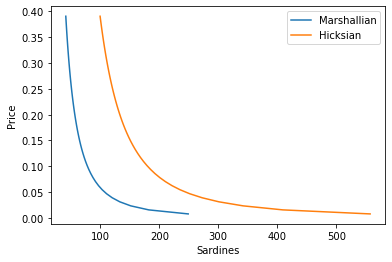

In [6]:
# Let’s look at Marshallian & Hicksian demands
U0 = r.indirect_utility(x0,p)

# Plot the demand curves
plt.plot([r.demands(U0,my_prices(p0,i=my_i),type="Marshallian")[my_i] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=my_i),type="Hicksian")[my_i] for p0 in P],P)

plt.ylabel('Price')
plt.xlabel(my_i)
plt.legend(("Marshallian","Hicksian"))

#### Welfare measures



In [7]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian') 
    
    
def compensated_nutrient_demand(U,p,z=None):
    c = r.demands(U,p,z=z,type='Hicksian')
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

def compensated_nutrient_adequacy_ratio(U,p):
    return (compensated_nutrient_demand(U,p)/hh_rdi.T).squeeze()

#### Price Changes, Revenue, and Compensating Variation



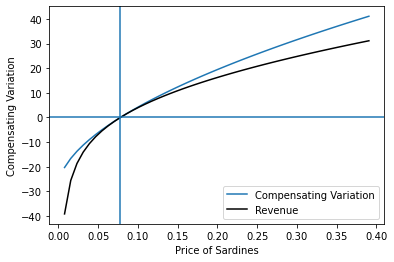

In [8]:
# Examine effects of price changes on revenue (if price change due to a tax or subsidy) 
# and compensating variation.
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=my_i),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[my_i])

#### Deadweight Loss



Text(0, 0.5, 'Deadweight Loss')

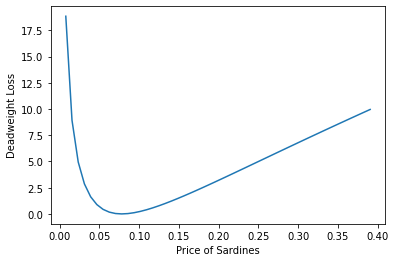

In [9]:
# Differences between revenue and compensating variation is deadweight-loss:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Deadweight Loss")